# Predict size of cluster from text content

### This variant splits without shuffling, after ordering by date, to test ability of a model trained on past data to predict virality of stories in future data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import scikitplot as skplt

from sklearn.utils import shuffle

%matplotlib inline

import lib.helper as helper

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
# Import various metrics by which to judge a model's performance
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Regression type measurements
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Import the ML models to try
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Tools for evaluating the model by running it repeatedly
# with variants of the data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

## 01.  Create features, labels, train-val-test split

In [4]:
# Load the corpus
df = pd.read_csv("working/RSS_clustered_louvain_3lim.csv")

In [5]:
# A quick utility function to pre-process the text
df["tokens"] = df["clean_text"].apply(helper.preprocess_description)
df['phrased_tokens'] = helper.get_phrased_nouns(df['clean_text'])

# Create variable for cluster size
df_size = pd.DataFrame(df['cluster'].value_counts())
df_size['cluster_label'] = df_size.index
df_size.columns = ['cluster_size', 'cluster']
df_size.head()

df = df.merge(df_size, on="cluster", how="left")

df = df[df['cluster'] != -1]
#df['cluster_size'] = np.where(df['cluster']==-1, 1.0, df['cluster_size'])

# Sort by date-order, latest last!
df['date_clean'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
df = df.sort_values("date_clean")

# Take a look at the features and labels
df[['cluster_size', 'tokens', 'phrased_tokens']].head()

C:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


,cluster_size,tokens,phrased_tokens
15704,39,"[jamal, khashoggi, timelin, saudi, journalist,...","[jamal_khashoggi, timelin, turkey, mr, khashog..."
11938,68,"[julian, assang, spi, ecuador, diplomat, staff...","[julian_assang, ecuador, london, wikileak]"
958,7,"[trump, news, presid, attack, immigr, el, paso...","[el_paso, california, donald_trump, el_paso, t..."
939,150,"[trump, syria, withdraw, hurt, fight, isi, pen...","[trump_syria, isi, pentagon, report, isi_syria..."
938,5,"[ebola, crisi, acceler, viru, kill, children, ...","[ebola, democrat_republ, congo]"


In [6]:
# vectorizer = TfidfVectorizer(decode_error="ignore", max_features=1000)
vectorizer = CountVectorizer(decode_error="ignore", max_features=5000)

# Create feature vectors
X = vectorizer.fit_transform(df['phrased_tokens'].apply(" ".join))

# Create Labels
y = np.asarray(df['cluster_size'].astype(float))

# Check that worked
print(X.shape, y.shape)

# Split the data, save 'test' for final pass
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

(4934, 5000) (4934,)


In [7]:
# Define the measurements we want to make (GridSearch will default to MSE)
#scoring = {'MSE': make_scorer(mean_squared_error),
#           'MAE': make_scorer(mean_absolute_error)}

parameters = {'alpha':[0.01, 0.03, 0.05, 0.07, 0.1, 0.5, 1.0, 2.0],
              'l1_ratio': [0.0, 0.5, 1.0]}

model = ElasticNet()

# Perform cross-validated grid-search
clf = GridSearchCV(estimator=model,
                   cv=5,
                   param_grid=parameters,
                   return_train_score=True,
                   n_jobs=10,
                   refit=True)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)

In [8]:
# Look at the performance of each hyperparameter combination
pd.DataFrame(clf.cv_results_)\
  [['params', 'mean_test_score', 'std_test_score']]\
  .sort_values("mean_test_score", ascending=False)

,params,mean_test_score,std_test_score
1,"{'alpha': 0.01, 'l1_ratio': 0.5}",0.396914,0.052016
11,"{'alpha': 0.07, 'l1_ratio': 1.0}",0.373094,0.084626
14,"{'alpha': 0.1, 'l1_ratio': 1.0}",0.371867,0.079281
8,"{'alpha': 0.05, 'l1_ratio': 1.0}",0.361707,0.090627
0,"{'alpha': 0.01, 'l1_ratio': 0.0}",0.359665,0.046959
4,"{'alpha': 0.03, 'l1_ratio': 0.5}",0.322916,0.045095
5,"{'alpha': 0.03, 'l1_ratio': 1.0}",0.321247,0.111628
7,"{'alpha': 0.05, 'l1_ratio': 0.5}",0.275498,0.043694
17,"{'alpha': 0.5, 'l1_ratio': 1.0}",0.267052,0.047235
3,"{'alpha': 0.03, 'l1_ratio': 0.0}",0.266112,0.042674


In [9]:
def help_get_coefs(fitted_model, feature_names):
    """
    Gets ordered table of coefficient names and magnitudes
    """
    df = pd.DataFrame({"name": feature_names,
                       "coefficient": fitted_model.coef_})
    
    # MAGNITUDES rather than VALUE determine importance
    df['abs_value'] = df['coefficient'].apply(abs)
    
    return df.sort_values("abs_value", ascending=False)

# In this call, retrieving final (selected and retrained)
# estimator from the grid search
coef_table = help_get_coefs(clf.best_estimator_, list(vectorizer.get_feature_names()))

coef_table

,name,coefficient,abs_value
596,brexit,113.409330,113.409330
4609,uk,113.149241,113.149241
1018,coronaviru_uk,101.769175,101.769175
559,bori_johnson,99.832963,99.832963
1460,eu,87.571370,87.571370
...,...,...,...
3099,name,0.000000,0.000000
3098,nalikul,0.000000,0.000000
305,autumn,0.000000,0.000000
2397,karachi,0.000000,0.000000


In [10]:
# How many features ultimately selected?
# (they're regularised to NEAR zero, so need a tolerance)
coef_table[coef_table['abs_value'] >= 2.0]

,name,coefficient,abs_value
596,brexit,113.409330,113.409330
4609,uk,113.149241,113.149241
1018,coronaviru_uk,101.769175,101.769175
559,bori_johnson,99.832963,99.832963
1460,eu,87.571370,87.571370
...,...,...,...
190,ann_frank,-2.005128,2.005128
4175,spiegel,-2.005114,2.005114
3734,renia,-2.005114,2.005114
1323,durham,2.002141,2.002141


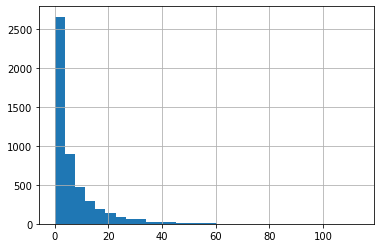

In [11]:
coef_table['abs_value'].hist(bins=30)

## Diagnostic Plots
I'm, to some degree, improvising my own because no single python package quite does everything I'd expect R to do for a linear regression...

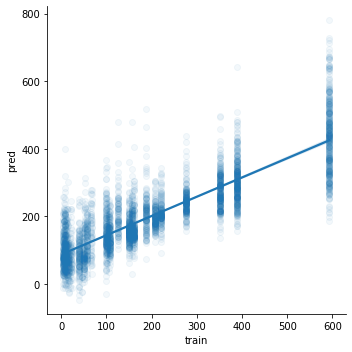

In [12]:
temp_df = pd.DataFrame({"train": y_train,
                        "pred": y_pred})

# Note this isn't the line of the actual regression model.
sns.lmplot(x="train", y="pred", data=temp_df, scatter_kws={"alpha":0.05})

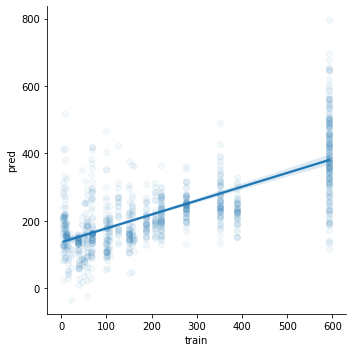

In [13]:
temp_df = pd.DataFrame({"train": y_test,
                        "pred": clf.best_estimator_.predict(X_test)})

# Note this isn't the line of the actual regression model.
sns.lmplot(x="train", y="pred", data=temp_df, scatter_kws={"alpha":0.05})

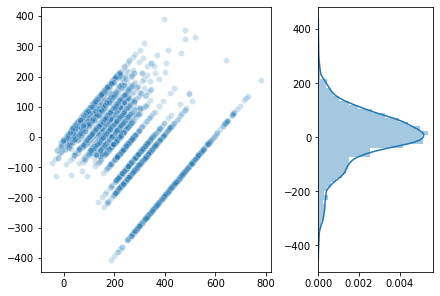

In [14]:
def help_plot_residuals(fitted_model, X, y):
    """
    Utility function:  Plot residual values for a given model
    and features + predictions
    """
    predicted = fitted_model.predict(X)
    residuals = predicted - y
    
    f = plt.figure(constrained_layout=True)
    gs = f.add_gridspec(3, 3)
    f_ax0 = f.add_subplot(gs[:, :-1])
    f_ax1 = f.add_subplot(gs[:, -1])
    
    # Residuals vs predicted
    sns.scatterplot(x=predicted, y=residuals, alpha=0.2, ax=f_ax0)
    
    # Hist of residuals
    sns.distplot(a=residuals, hist=True, vertical=True, ax=f_ax1)


help_plot_residuals(clf.best_estimator_, X_train, y_train)

In [15]:
# Fit a traditional Linear Regression Model so that we can examine the p-values and r2 values
# of different features

import scipy.stats as stats
import statsmodels.api as sm
from patsy import dmatrices

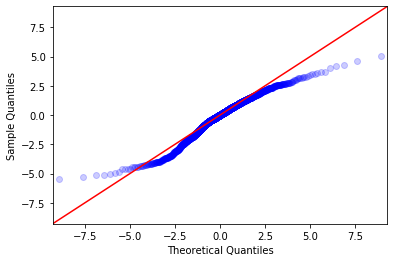

In [16]:
# Q-Q plot to gauge suitability of normality assumption
res = clf.best_estimator_.predict(X_train) - y_train

fig = sm.qqplot(res, stats.t, fit=True, line='45', alpha=0.2)
plt.show()

In [17]:
res

array([  26.92502118,   96.68562332,   70.27774347, ...,  -15.69436751,
        -13.8517452 , -327.91940112])

## Examine feature significance using an equivalent model in StatsModels

In [18]:
df_stats = pd.DataFrame(data=X_train.todense(), columns=list(vectorizer.get_feature_names()))
df_stats.head()

df_stats['StorySize'] = y_train